# Imports

In [2]:
import numpy as np
import pandas as pd
import torch.optim as optim
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
#keras
import tensorflow as tf
from tensorflow import keras
#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\ASUSS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ASUSS\anaconda3\envs\DL\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# EDA

In [4]:
column_names = ['sentiment', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=column_names)
df = df[df['sentiment'].isin([0, 4])]
# Convert target column to binary: 4 (positive) to 1, 0 (negative) to 0
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 4 else 0)
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)
print(df['sentiment'].value_counts())


sentiment
0    800000
1    800000
Name: count, dtype: int64


In [5]:
X = df['text'].values
y = df['sentiment'].values

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [7]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()

I am one hot encoding the sentiment values so it becomes a classification problem instead of regression.

In [13]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()

In [15]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}" )

TRAINING DATA: 1440000
VALIDATION DATA: 160000


In [17]:
y_train[160000]

array([1., 0.])

# Tokenizing the Sentences


In [20]:
MAX_LEN=256

In [22]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        #if len(encoded['input_ids']) == 128:
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    #print(input_ids, len(attention_masks))
    return np.array(input_ids),np.array(attention_masks)

In [24]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

C:\Users\ASUSS\anaconda3\envs\DL\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [26]:
train_input_ids, train_attention_masks = tokenize(X_train[:300000], MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
#test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [27]:
train_input_ids.shape

(300000, 256)

count = 0
val=0
for i in train_input_ids:
    val+=1
    if len(i)!=128:
        count+=1
        print(val)
print(count)

# Creating the BERT Model 

Downloading the BERT-small and then fine tuning it 


In [33]:
bert_model = TFBertModel.from_pretrained('google/bert_uncased_L-4_H-512_A-8',from_pt=True)

C:\Users\ASUSS\anaconda3\envs\DL\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from 

In [35]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings = bert_model([input_ids,attention_masks])[1]
    output = tf.keras.layers.Dense(2, activation="softmax")(embeddings)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [45]:
custom_objects = {
    "TFBertModel": TFBertModel
}
# Loading  the model after training and closing a session (This is for my use only as I cannot train the model everytime I open the notebook, so i saved it)
model = tf.keras.models.load_model('bert_s_tuned.h5', custom_objects=custom_objects, compile=False)

In [49]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.BinaryCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy()
model.compile(opt, loss=loss, metrics=accuracy)

In [26]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   2876364   ['input_1[0][0]',             
 el)                         ngAndCrossAttentions(last_   8          'input_2[0][0]']             
                             hidden_state=(None, 256, 5                                           
                             12),                                                             

# Training and Testing

In [33]:
y_train.shape

(1440000, 2)

I am training the model only on a part of the dataset as my laptop and kaggle cannot handle more than this(this itself takes roughly 3 hrs for the model to train)

In [34]:
history = model.fit([train_input_ids,train_attention_masks], y_train[:300000], validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4


I0000 00:00:1733630626.366686    1277 service.cc:145] XLA service 0x7dc21409b890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733630626.366735    1277 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733630626.546690    1277 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9375/9375 [==============================] - 1966s 207ms/step - loss: 0.4242 - categorical_accuracy: 0.8041 - val_loss: 0.3796 - val_categorical_accuracy: 0.8318
Epoch 2/4
9375/9375 [==============================] - 1936s 207ms/step - loss: 0.3658 - categorical_accuracy: 0.8372 - val_loss: 0.3618 - val_categorical_accuracy: 0.8412
Epoch 3/4
9375/9375 [==============================] - 1935s 206ms/step - loss: 0.3356 - categorical_accuracy: 0.8530 - val_loss: 0.3632 - val_categorical_accuracy: 0.8438
Epoch 4/4
9375/9375 [==============================] - 1935s 206ms/step - loss: 0.3097 - categorical_accuracy: 0.8666 - val_loss: 0.3650 - val_categorical_accuracy: 0.8453


In [93]:
result_bert = model.predict([val_input_ids,val_attention_masks])

5000/5000 [==============================] - 284s 57ms/step


In [94]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [40]:
confusion_matrix(y_valid.argmax(1), y_pred_bert.argmax(1))

array([[67932, 12068],
       [12685, 67315]])

Text(50.722222222222214, 0.5, 'Actual')

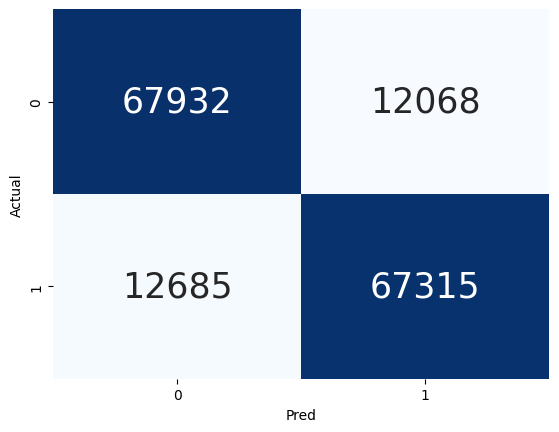

In [58]:
sns.heatmap(confusion_matrix(y_valid.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False,  annot_kws={"size":25})
plt.xlabel('Pred')
plt.ylabel('Actual')

# Trying the model for different Inputs


In [52]:
def sentimentAnalysis(sentence):
    ip_id, ip_mask= tokenize([sentence],256)
    op = model.predict([ip_id,ip_mask])
    if op[0][0] >0.5 :
        print('Sentiment:Negative')
    else:
        print('Sentiment:Positive')

U can try giving different sentences as inputs and check

In [80]:
sentimentAnalysis("i am happy today")

1/1 [==============================] - 0s 99ms/step
Sentiment:Positive


# Using Gradio to deploy the model on a GUI

In [78]:
import gradio as gr
def predict(text):
    ip_id, ip_mask= tokenize([text],256)
    op = model.predict([ip_id,ip_mask])
    if op[0][0] >0.5 :
        return 'Sentiment: Negative'
    else:
        return 'Sentiment: Positive'

interface = gr.Interface(fn=predict, inputs="text", outputs="text", live=True)
interface.launch()


Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
